
=== 最適スコア: 44 ===
=== 1回戦カード ===
T1 vs B1 
T2 vs B2 
T3 vs B3 
T4 vs B4 
T5 vs B5 
T6 vs B8 （過去対戦あり）
T7 vs B7 
T8 vs B6 （過去対戦あり）


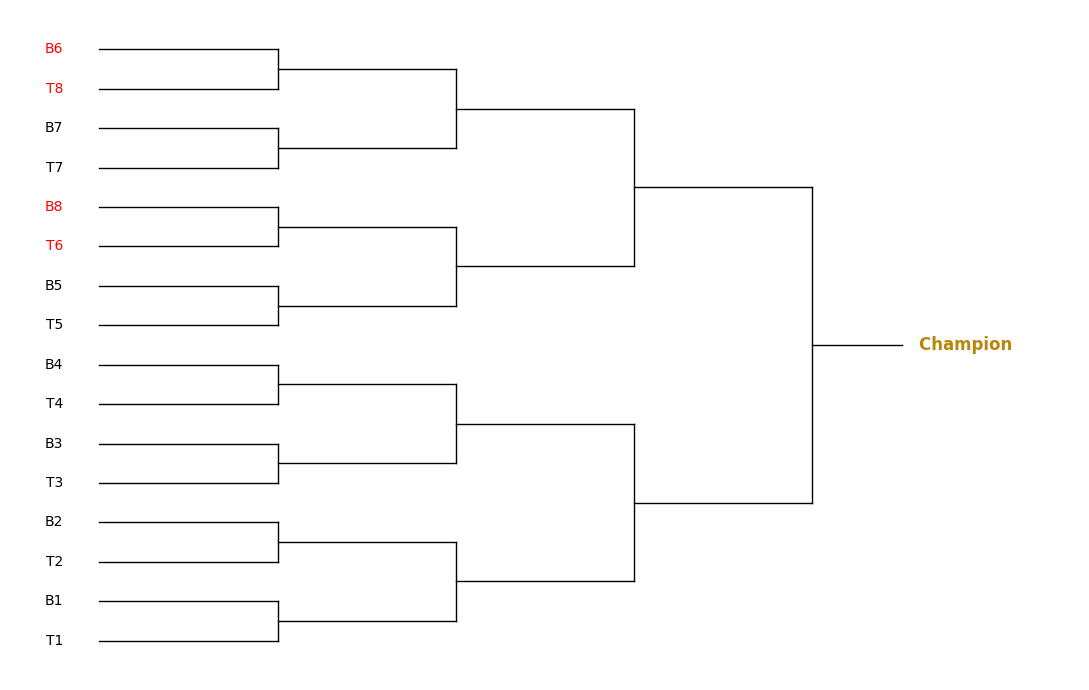

In [23]:
import random
import math
import matplotlib.pyplot as plt

# --- トーナメント木構築 ---
def build_tournament_tree(n=16):
    tree = {}
    current = list(range(n))
    next_nodes = []
    node_id = n
    while len(current) > 1:
        for i in range(0, len(current), 2):
            tree[node_id] = (current[i], current[i+1])
            next_nodes.append(node_id)
            node_id += 1
        current = next_nodes
        next_nodes = []
    return tree

# --- LCAラウンドを求める ---
def find_round(pos_a, pos_b, tree):
    parent = {}
    for node, (l, r) in tree.items():
        parent[l] = node
        parent[r] = node

    def ancestors(p):
        res = []
        while p in parent:
            p = parent[p]
            res.append(p)
        return res

    a_anc = ancestors(pos_a)
    b_anc = ancestors(pos_b)
    for i, node in enumerate(a_anc):
        if node in b_anc:
            return len(a_anc) - i
    return 0

# --- スコア計算 ---
def score_arrangement(arrangement, past_matches, tree):
    player_pos = {player: i for i, player in enumerate(arrangement)}
    total = 0
    for a, b in past_matches:
        if a in player_pos and b in player_pos:
            r = find_round(player_pos[a], player_pos[b], tree)
            total += r**2
    return total

# --- 焼きなまし法 ---
def simulated_annealing(top_players, bottom_players, past_matches, tree, steps=20000, temp_start=50.0, temp_end=0.1):
    arrangement = []
    for t, b in zip(top_players, bottom_players):
        arrangement.extend([t, b])

    best = arrangement[:]
    best_score = score_arrangement(arrangement, past_matches, tree)
    current = best[:]
    current_score = best_score

    for step in range(steps):
        T = temp_start * ((temp_end / temp_start) ** (step / steps))
        i, j = random.sample(range(8, 16), 2)
        new = current[:]
        new[i], new[j] = new[j], new[i]
        new_score = score_arrangement(new, past_matches, tree)
        delta = new_score - current_score
        if delta > 0 or random.random() < math.exp(delta / T):
            current = new
            current_score = new_score
            if new_score > best_score:
                best_score = new_score
                best = new[:]
    return best, best_score

# --- 角張りトーナメント図 + Champion ---
def draw_square_tournament(arrangement, past_matches):
    n = 16
    rounds = int(math.log2(n))
    fig, ax = plt.subplots(figsize=(11, 7))
    ax.axis('off')

    # 各プレイヤーの座標
    positions = {i: (0, i) for i in range(n)}

    # 線を描く関数
    def draw_match(x, left_idx, right_idx, round_num):
        lx, ly = positions[left_idx]
        rx, ry = positions[right_idx]
        mid_y = (ly + ry) / 2
        nx = x + 1
        # 折れ線を描く
        ax.plot([x, nx], [ly, ly], color='black', lw=1)
        ax.plot([x, nx], [ry, ry], color='black', lw=1)
        ax.plot([nx, nx], [ly, ry], color='black', lw=1)
        node_id = f"R{round_num}_{left_idx}_{right_idx}"
        positions[node_id] = (nx, mid_y)
        return node_id

    # 各ラウンドの枝を作成
    current_layer = list(range(n))
    x = 0
    all_nodes = []
    for r in range(rounds):
        next_layer = []
        for i in range(0, len(current_layer), 2):
            node = draw_match(x, current_layer[i], current_layer[i+1], r)
            next_layer.append(node)
            all_nodes.append(node)
        current_layer = next_layer
        x += 1

    # 決勝（最後に1ノード残る）
    final_node = current_layer[0]
    fx, fy = positions[final_node]

    # Champion ライン
    champion_x = fx + 0.5
    ax.plot([fx, champion_x], [fy, fy], color='black', lw=1)
    ax.text(champion_x + 0.1, fy, "Champion ", va="center", fontsize=12, fontweight="bold", color="darkgoldenrod")

    # プレイヤー名を描画
    for i in range(0, n, 2):
        a, b = arrangement[i], arrangement[i+1]
        y1, y2 = positions[i][1], positions[i+1][1]
        color = "red" if (a,b) in past_matches or (b,a) in past_matches else "black"
        ax.text(-0.2, y1, a, ha="right", va="center", color=color, fontsize=10)
        ax.text(-0.2, y2, b, ha="right", va="center", color=color, fontsize=10)

    ax.set_xlim(-0.5, rounds + 1.5)
    ax.set_ylim(-1, n)
    # plt.title("角張りトーナメント表（過去対戦は赤）", fontsize=14)
    plt.tight_layout()
    plt.show()

# --- 実行 ---
if __name__ == "__main__":
    top_players = [f"T{i+1}" for i in range(8)]
    bottom_players = [f"B{i+1}" for i in range(8)]

    past_matches = {
        ("T1","B3"),
        ("T2","B5"),
        ("T3","B7"),
        ("T4","B1"),
        ("T5","B2"),
        ("T6","B8"),
        ("T7","B4"),
        ("T8","B6"),
    }

    tree = build_tournament_tree(16)
    best_arrangement, best_score = simulated_annealing(
        top_players, bottom_players, past_matches, tree
    )

    print(f"\n=== 最適スコア: {best_score} ===")
    print("=== 1回戦カード ===")
    for i in range(0, 16, 2):
        a, b = best_arrangement[i], best_arrangement[i+1]
        flag = "（過去対戦あり）" if (a,b) in past_matches or (b,a) in past_matches else ""
        print(f"{a} vs {b} {flag}")

    draw_square_tournament(best_arrangement, past_matches)
